In [143]:
import pandas as pd
import numpy as np

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing import sequence, text
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
! pip install scikit-multilearn


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# expPath='/content/drive/My Drive/Colab Notebooks/'
food_df = pd.read_csv('Food Label Challenge.csv')

We can see that we have almost 70% glueten free and 64% non Vegan resipises. By looking at the "food_df.describe()" results we can see that there are 975/1000 unique names - which means that the "name" column of the food doesn't help us predict anything becuse we probabley won't see it again given it's uniquness. We also check if we have only 2 categories in the boolean varaibles 

In [145]:
# explor data - 
import seaborn as sns
food_df.describe()

,name,ingredients,GlutenFree,Vegetarian,Vegan,foodType
count,1000,1000,1000,1000,1000,1000
unique,975,978,2,2,2,50
top,Superfood Smoothie,300g sushi rice//2 tbsp rice or white wine vin...,True,True,False,Fish
freq,3,2,709,583,644,182


In [146]:
food_df.tail()

,name,ingredients,GlutenFree,Vegetarian,Vegan,foodType
995,Honey Lemon Yogurt,1/2 cup greek yogurt//2 tsp honey//2 tsp lemon...,True,True,False,Yoghurt
996,Acai breakfast,3.5 oz frozen acai//1/2 cup blueberries//1/2 b...,False,True,True,Porridge
997,Orange honey yogurt with flaxseed & cinnamon,1 cup 2% greek yogurt//1/4 cup freshly squeeze...,True,True,False,Yoghurt
998,Dairy-Free Strawberry Smoothie,2 cups Frozen strawberries//1 cup Cold water//...,True,True,True,Smoothies
999,Raspberry Coconut Yogurt,1 cup coconut meat (Thai coconut)//1/2 cup gre...,True,True,False,Yoghurt


We have catgories that are both gluten free and non gluten free. So basicly we need to find a connection beween the ingredients and the categories. Our modle will have bad results predicting the food type - some of the food types only apper once - which means that some of them might only appear on the test class - as they did not apear before on the training set (unseen)

In [147]:
food_df[['foodType','GlutenFree','Vegetarian','Vegan']].groupby('foodType').describe()


GlutenFree                     ... Vegan                   
                  count unique    top freq  ... count unique    top freq
foodType                                    ...                         
Beans                19      2   True   17  ...    19      2   True   16
Beef                 13      2  False    7  ...    13      1  False   13
Cakes                 4      2   True    3  ...     4      1  False    4
Casseroles            3      2   True    2  ...     3      2  False    2
Cereals              18      2  False   11  ...    18      2   True   10
Cookies               7      2  False    4  ...     7      2   True    5
Couscous             28      1  False   28  ...    28      2  False   15
Crepes                1      1  False    1  ...     1      1  False    1
Dips                  9      1   True    9  ...     9      2   True    7
DriedFruit            3      2   True    2  ...     3      2   True    2
Drinks                4      1   True    4  ...     4      1   True    4
Eggs                 10      2   True    9  ...    10      1  False   10
EnergyBars            2      2   True    1  ...     2      2   True    1
Fish                182      2   True  136  ...   182      1  False  182
Fruits               28      2   True   25  ...    28      2   True   16
Icecream              8      1   True    8  ...     8      2   True    5
Juices                4      1   True    4  ...     4      1   True    4
Lamb                 18      2   True   14  ...    18      1  False   18
Legumes               2      1   True    2  ...     2      1   True    2
Lentils              17      2   True   13  ...    17      2   True   12
Meat                  7      2   True    4  ...     7      1  False    7
MockMeats             2      1  False    2  ...     2      2   True    1
Noodles               8      2  False    5  ...     8      2  False    5
NutsAndSeeds          4      2   True    3  ...     4      2   True    2
Pancakes              3      1  False    3  ...     3      1  False    3
Pasta                21      2  False   19  ...    21      2  False   14
Pastries              3      1  False    3  ...     3      1  False    3
Peas                  1      1   True    1  ...     1      1   True    1
Pie                   1      1   True    1  ...     1      1  False    1
Pizza                 1      1  False    1  ...     1      1  False    1
Pork                 14      2   True    9  ...    14      1  False   14
Porridge             10      2   True    5  ...    10      2   True    8
Poultry              26      2  False   15  ...    26      1  False   26
Quinoa                6      1   True    6  ...     6      2   True    3
Rice                 24      2   True   21  ...    24      2   True   20
Salads              161      2   True  132  ...   161      2  False   93
Sandwiches           17      1  False   17  ...    17      2  False   11
Seafood              27      2   True   17  ...    27      1  False   27
Smoothies            46      2   True   40  ...    46      2  False   33
Snacks                4      2   True    3  ...     4      1   True    4
Soups                54      2   True   48  ...    54      2  False   29
Stew                 17      2   True   13  ...    17      2   True   10
Stuffed              14      2   True   12  ...    14      2  False   13
Sushi                 4      1  False    4  ...     4      2   True    2
Sweets                5      2   True    4  ...     5      2  False    3
Tea                   7      1   True    7  ...     7      2   True    4
Tofu                  8      2   True    4  ...     8      2   True    7
Vegetables          102      2   True   86  ...   102      2   True   69
Wraps                16      2  False   11  ...    16      2  False   14
Yoghurt               7      1   True    7  ...     7      1  False    7

[50 rows x 12 columns]

In [0]:
food_df['ingredients_count'] = food_df.ingredients.str.count("//")
food_df.columns
food_df= food_df[['name', 'ingredients','ingredients_count', 'GlutenFree', 
                  'Vegetarian', 'Vegan', 'foodType']]

Looking at the food types we can see that we have mostly fish and salads and more gluten free foods. Which might create a bias in the model's performence, it is something to account for  

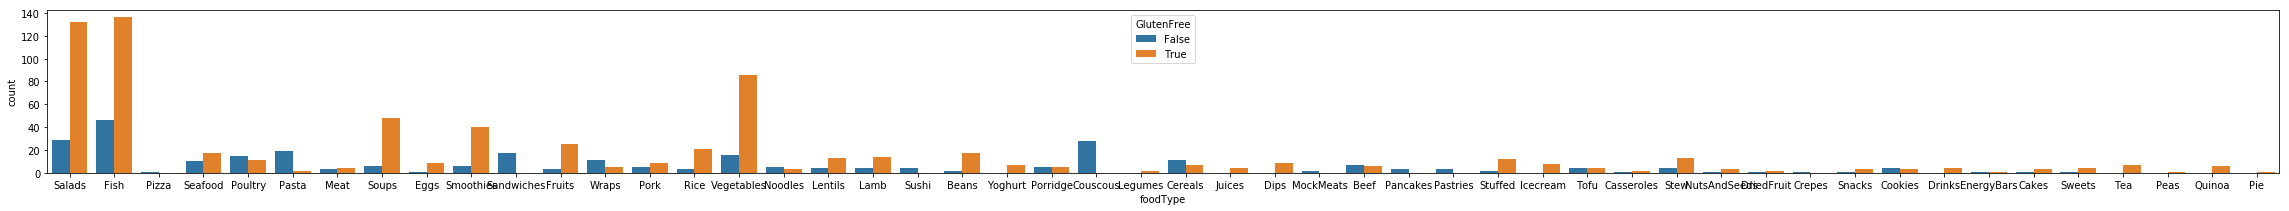

In [149]:
# sns.catplot(x ='foodType', y = 'ingredients_count', data = food_df, kind='kde')
f, ax = plt.subplots(figsize=(40, 3))
sns.countplot(x="foodType",hue="GlutenFree", data=food_df)

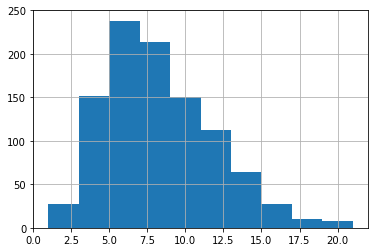

In [150]:
food_df.ingredients_count.hist(bins = 10)

Looking at the Word Cloud gives us an idea on the most frequent words we would like to address, although word normalizers like tf-idf will decrease the impact of these words

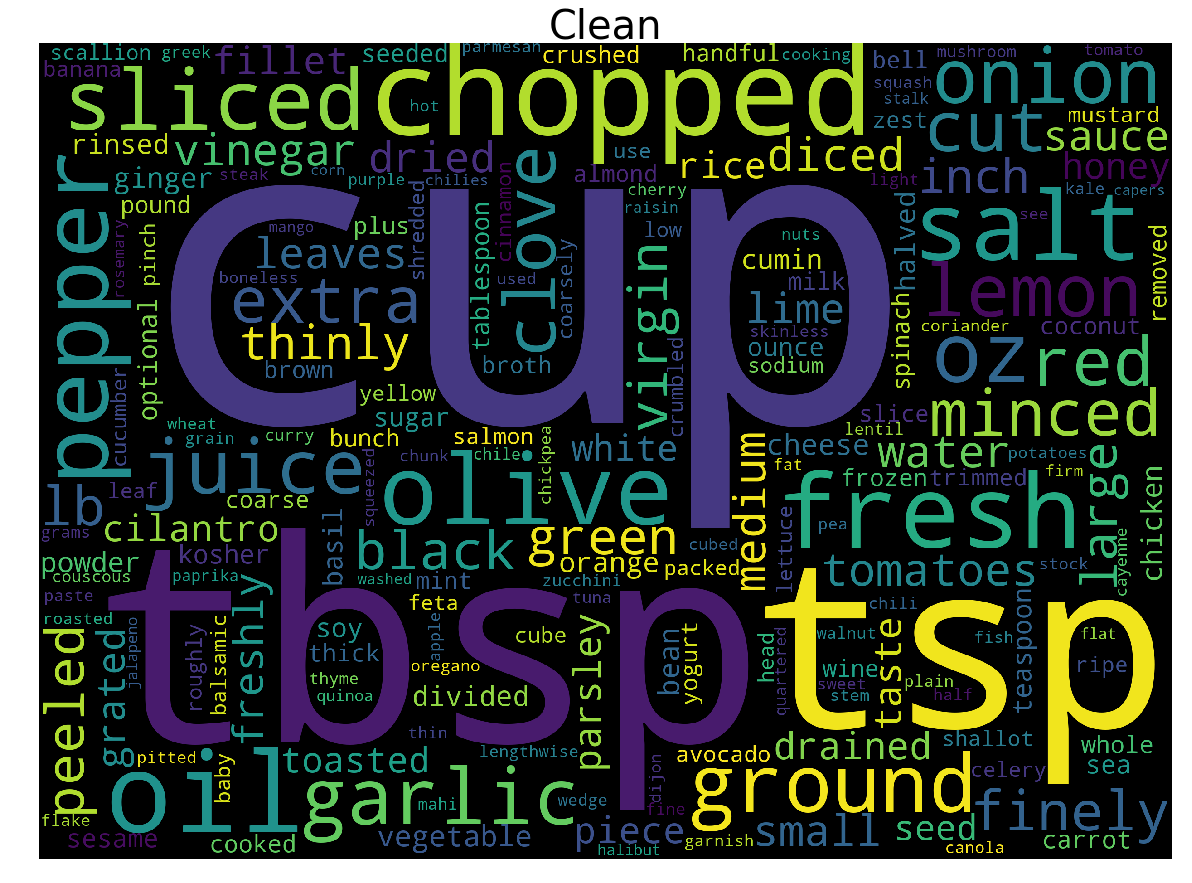

In [151]:

from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(30,15))
# clean
text = food_df.ingredients.values
cloud_ingredients = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Clean",fontsize=40)
plt.imshow(cloud_ingredients)


In [0]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#|-]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = re.sub("\d+", "", cleaned)    
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

In [153]:
data = food_df
data['ingredients'] = data['ingredients'].apply(cleanPunc)
data['ingredients'].head()

0    pounds boneless  skinless chicken breasts  tri...
1    pounds asparagus  tough ends trimmed  cut into...
2    pound prepared pizza dough  preferably wholewh...
3    pound raw shrimp    per pound   peeled and dev...
4    tablespoons lemon juice   tablespoons extravir...
Name: ingredients, dtype: object

Getting rid of some words although tf-idf should do the heavy lifting

In [154]:
stop_words = set(stopwords.words('english'))
stop_words.update(['pound','pounds','tablespoons','juice','trimmed',
                   'cup','cups','cut','lemon','inch','oil','garlic','per'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)
data['ingredients'] = data['ingredients'].apply(removeStopWords)
data['ingredients'].head()

0     boneless  skinless chicken breasts       shre...
1     asparagus  tough ends      pieces    chili po...
2     prepared pizza dough  preferably wholewheat  ...
3     raw shrimp        peeled  deveined  tails lef...
4          extravirgin olive    clove   minced  Fre...
Name: ingredients, dtype: object

In [0]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
data['ingredients'] = data['ingredients'].apply(stemming)

In [156]:
data['ingredients'].head()

0    boneless skinless chicken breast shred cook ch...
1    asparagus tough end piec chili powder teaspoon...
2    prepar pizza dough prefer wholewheat prepar pe...
3    raw shrimp peel devein tail left teaspoon salt...
4    extravirgin oliv clove minc fresh ground peppe...
Name: ingredients, dtype: object

In [157]:
data.head()

,name,ingredients,ingredients_count,GlutenFree,Vegetarian,Vegan,foodType
0,"Chicken, Charred Tomato & Broccoli Salad",boneless skinless chicken breast shred cook ch...,9,True,False,False,Salads
1,Chili-Rubbed Tilapia with Asparagus & Lemon,asparagus tough end piec chili powder teaspoon...,8,True,False,False,Fish
2,"Grilled Pizza with Pesto, Tomatoes & Feta",prepar pizza dough prefer wholewheat prepar pe...,7,False,True,False,Pizza
3,Shrimp with Mango & Basil,raw shrimp peel devein tail left teaspoon salt...,7,True,False,False,Seafood
4,Thyme- & Sesame-Crusted Halibut,extravirgin oliv clove minc fresh ground peppe...,10,True,False,False,Fish


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train['ingredients'])
vectorizer.fit(test['ingredients'])
x_train = vectorizer.transform(train['ingredients'])
y_train = train.drop(labels = ['name','ingredients_count','ingredients'], axis=1)
x_test = vectorizer.transform(test['ingredients'])
y_test = test.drop(labels = ['name','ingredients_count','ingredients'], axis=1)

In [0]:
categories = list(['GlutenFree','Vegetarian','Vegan','foodType'])

Try to train a modle to perform multi-label classification

In [160]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
for category in categories:
    print('**Processing {} ...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, y_train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))
    print("\n")

**Processing GlutenFree ...**
Test accuracy is 0.73


**Processing Vegetarian ...**
Test accuracy is 0.7766666666666666


**Processing Vegan ...**
Test accuracy is 0.6866666666666666


**Processing foodType ...**
Test accuracy is 0.34




A different calssfier gives better results 

In [161]:

SVC_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(x_train, y_train[category])
    # compute the testing accuracy
   
    prediction = SVC_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], prediction)))

... Processing GlutenFree
Test accuracy is 0.8133333333333334
... Processing Vegetarian
Test accuracy is 0.8666666666666667
... Processing Vegan
Test accuracy is 0.8233333333333334
... Processing foodType
Test accuracy is 0.53


In [0]:
# from sklearn.preprocessing import OrdinalEncoder
# oe = OrdinalEncoder()

# data[['GlutenFree',	'Vegetarian',	'Vegan','foodType']] = oe.fit_transform(data[['GlutenFree',	'Vegetarian',	'Vegan','foodType']])

# train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

# vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
# vectorizer.fit(train['ingredients'])
# vectorizer.fit(test['ingredients'])
# x_train = vectorizer.transform(train['ingredients'])
# y_train = train.drop(labels = ['name','ingredients_count','ingredients'], axis=1)
# x_test = vectorizer.transform(test['ingredients'])
# y_test = test.drop(labels = ['name','ingredients_count','ingredients'], axis=1)



If I had more time - 
1. On the reggresion calssiffier pipeline I'd add feature importance with - InvertableHashingVectorizer so I could have a better idea which word influences the most
2. I would use a convonoational nn to get better results but the implementation wasn't out-of-the-box. 
By using convonoational nn we can try to do boosting on the gluten free misclassifications. 
3. In convonoational nn we can also give a bigger penalty on misclassifications (. Also having a differnt accuracy/recall score can give better performance and by looking at the ROC/ACU we can find a better treshold to be more accurate.

 